Hamiltonian Monte Carlo
-----
#### Ilan Man and Sanjay Hariharan

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy.linalg as la
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [26]:
def hamiltonian_monte_carlo(y, leap, delta, Cov):
    """
    
    Hamiltonian Monte Carlo algorithm for a bivariate normal

    Parameters
    ----------
    y : ndarray of shape 2 x N. Stores (y1, y2) data points.
    leap: number of steps of leap frog
    delta: step size for discrete approximation
    Cov: covariance matrix
    
    Returns
    -------
    y : ndarray of shape 2 x N. Transformed variable with HMC samples
    
    Raises
    ------
    Error if leap or delta are negative
    Error if covariance is not positive semi definite
    
    """
    
    assert(leap > 0), "leap must be positive"
    assert(delta > 0), "delta must be positive"
    assert(np.all(la.eigvals(Cov)>=0)), "Covariance matrix must be Positive Semi-Definite"
    
    """ Hamiltonian helper functions """
    
    def potential_energy(x, Cov):
        return x.dot(la.inv(Cov.T)).dot(x.T)

    def grad_potential_energy(x, Cov):
        return x.dot(la.inv(Cov))

    def kinetic_energy(p):
        return np.sum(p.T.dot(p)/2)
    
    N = y.shape[0]
    
    for t in range(1,N):

        #   SAMPLE RANDOM MOMENTUM
        p0 = np.random.randn(2)

        #   SIMULATE HAMILTONIAN DYNAMICS
        #   FIRST 1/2 STEP OF MOMENTUM
        p_star = p0 - 1/2*delta/2*grad_potential_energy(y[t-1,:], Cov)

        #   FIRST FULL STEP FOR POSITION/SAMPLE
        y_star = y[t-1,:] + delta*p_star

        #   FULL STEPS
        for i in range(leap):
            # MOMENTUM
            p_star = p_star - delta*grad_potential_energy(y_star, Cov)
            # POSITION/SAMPLE
            y_star = y_star + delta*p_star

        p_star = p_star - 1/2*delta*grad_potential_energy(y_star, Cov)

        U0 = potential_energy(y[t-1,:], Cov)
        U_star = potential_energy(y_star, Cov)

        K0 = kinetic_energy(p0)
        K_star = kinetic_energy(p_star)

        # acceptance ratio
        alpha = min(1, np.exp((U0 + K0) - (U_star + K_star)))

        # accept/reject criterion        
        y[t,:] = y_star if np.random.random() < alpha else y[t-1,:]
        
    return y


In [27]:
def metropolis_hastings_MC(y, Cov):
    """
    Metropolis Hastings Monte Carlo algorithm for a bivariate normal

    Parameters
    ----------
    y : ndarray of shape 2 x N. Stores (y1, y2) data points.
    Cov: covariance matrix
    
    Returns
    -------
    y : ndarray of shape 2 x N. Transformed variable with HMC samples
    
    Raises
    ------
    Error if covariance is not positive semi definite
    
    """
    
    assert(np.all(la.eigvals(Cov)>=0)), "Covariance matrix must be Positive Semi-Definite"
    
    N = y.shape[0]
    
    def posterior(x, Cov):
        return stats.multivariate_normal.pdf(x, mean = np.array([0,0]), cov = Cov)
    
    for t in range(1,N):

        # multivariate normal pproposal
        y_star = np.random.multivariate_normal(y[t-1,:], np.eye(2))

        # acceptance ratio
        alpha = min(1, posterior(y_star, Cov)/posterior(y[t-1,:], Cov))
        
        # accept/reject criterion
        y[t,:] = y_star if np.random.random() < alpha else y[t-1,:]

    return y

In [34]:
# INITIAL STATE for bivariate normal
N = 1000
corr = 0.8
COVARIANCE = np.array([[1,corr],
                       [corr,1]])
x = np.zeros(2*N).reshape(N,2)
x[:] = np.array([4,3])

In [35]:
delta = 0.3
leap = 50
x_HMC = hamiltonian_monte_carlo(x.copy(), leap, delta, COVARIANCE)
x_MHMC = metropolis_hastings_MC(x.copy(), COVARIANCE)

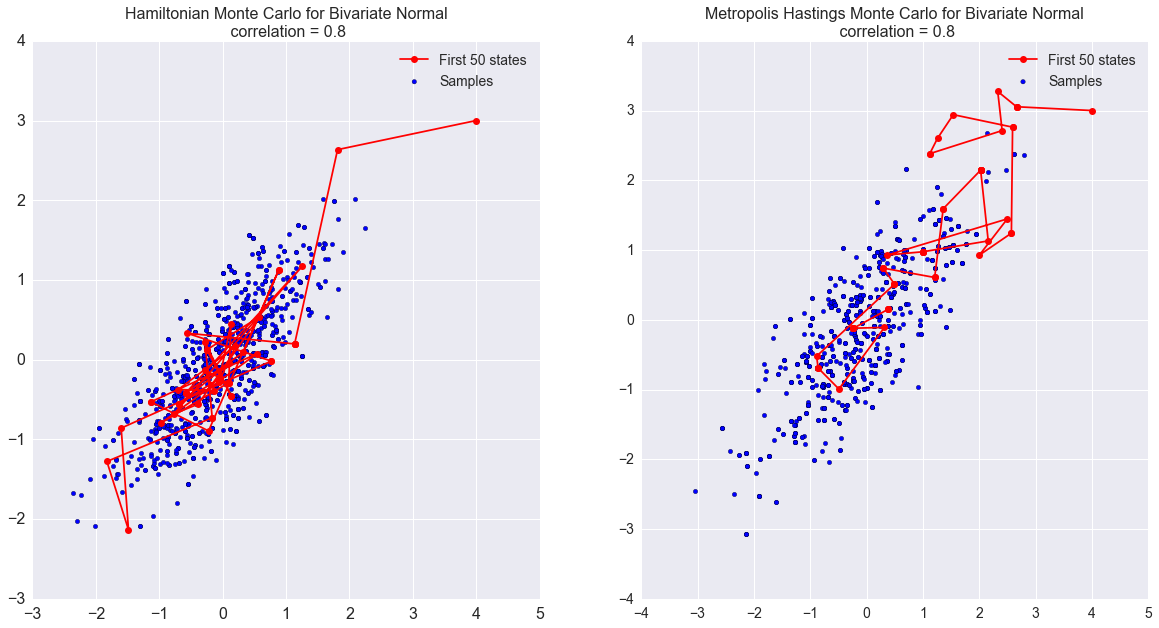

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axes[0].scatter(x_HMC[:,0],x_HMC[:,1])
axes[0].plot(x_HMC[:50,0],x_HMC[:50,1],'ro-')
axes[0].legend(['First 50 states','Samples'],fontsize=14)
axes[0].set_title("Hamiltonian Monte Carlo for Bivariate Normal\n correlation = {}".format(corr),size=16)
axes[0].tick_params(axis='both', which='major', labelsize=16)

axes[1].scatter(x_MHMC[:,0],x_MHMC[:,1])
axes[1].plot(x_MHMC[:50,0],x_MHMC[:50,1],'ro-')
axes[1].legend(['First 50 states','Samples'],fontsize=14)
axes[1].set_title("Metropolis Hastings Monte Carlo for Bivariate Normal\n correlation = {}".format(corr),size=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)

pass

In [16]:
# real dataset
Data = pd.read_csv("MV_Data.csv")

In [37]:
# scale data
std_scale = preprocessing.StandardScaler().fit(Data)
Data = std_scale.transform(Data)
X = Data[:,1:5]
Y = Data[:,5]

In [41]:
b0 = np.zeros(4)
E0 = np.eye(4)
a = 1
b = 1

n = X.shape[0]

N = 10000

Beta = np.zeros(N*4).reshape(N,4)
Tau = np.zeros(N)

for j in range(N-1):
    
    #Update Beta
    Mean = np.dot(la.inv(la.inv(E0) + np.dot(X.T, X)*Tau[j]),(np.dot(la.inv(E0), b0) + np.dot(X.T, Y)*Tau[j]))
    Var = la.inv(la.inv(E0) + np.dot(X.T, X)*Tau[j])
    
    Beta[j+1,:] = np.random.multivariate_normal(Mean, Var)
    
    #Update Tau
    Tau[j+1] = np.random.gamma(a + n/2, (b + (1/2)*np.dot(Y - np.dot(X,Beta[j+1,:]).T,(Y - np.dot(X, Beta[j+1,:]))))**(-1))

    if j%1000 == 0:
        print(j)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [42]:
print("Tau Estimate: ",np.mean(Tau[1000:]))
print("Beta Estimate: ", np.mean(Beta[1000:,:], axis = 0))

('Tau Estimate: ', 4783.9726318640778)
('Beta Estimate: ', array([-0.86350883, -0.17416434,  0.02160338, -0.13521523]))


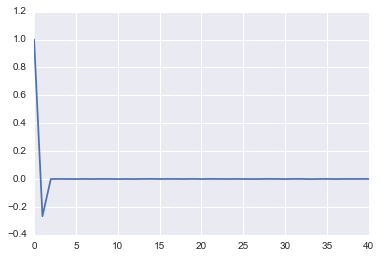

In [43]:
from statsmodels.tsa.stattools import acf
plt.plot(acf(Beta[:,1]))

In [21]:
def MH_Posterior(Beta1, Beta2, Beta3, Beta4, Tau):
    
    Beta = np.array([Beta1, Beta2, Beta3, Beta4])
        
    Log_Lik = (n/2)*np.log(Tau) - (Tau/2) * np.dot(Y - np.dot(X,Beta).T,(Y - np.dot(X, Beta)))
    Beta_Prior = stats.multivariate_normal(mean = b0, cov = E0)
    Tau_Prior = stats.gamma(a = 1)
    return(Log_Lik + Beta_Prior.logpdf(Beta) + Tau_Prior.logpdf(Tau))
    

In [600]:
"""
def MH_Posterior2(Beta, Tau):
    
        
    Log_Lik = (n/2)*np.log(Tau) - (Tau/2) * np.dot(Y - np.dot(X,Beta).T,(Y - np.dot(X, Beta)))
    Beta_Prior = stats.multivariate_normal(mean = b0, cov = E0)
    Tau_Prior = stats.gamma(a = 1)
    return(Log_Lik + Beta_Prior.logpdf(Beta) + Tau_Prior.logpdf(Tau))

N = 10000
Beta_MH = np.array([0,0,0,0]).reshape(1,4)
Tau_MH = np.array([1])

Beta_Tuning = np.eye(4)
Tau_Tuning = 1

Beta_accept = 0
Tau_accept = 0

for t in range(N):
    
    #Propose Beta
    Beta_Star = np.random.multivariate_normal(mean = Beta_MH[-1,:], cov = Beta_Tuning)
    rho = MH_Posterior(Beta_Star, Tau_MH[-1]) - MH_Posterior(Beta_MH[-1,:], Tau_MH[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Beta_accept += 1
        Beta_MH = np.vstack([Beta_MH, Beta_Star])
    
    #Propose Tau
    Tau_Star = np.random.normal(loc = Tau_MH[-1], scale = Tau_Tuning)
    rho = MH_Posterior(Beta_MH[-1,:], Tau_Star) - MH_Posterior(Beta_MH[-1,:], Tau_MH[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Tau_accept += 1
        Tau_MH = np.append(Tau_MH, Tau_Star)
        
"""

In [22]:
N = 10000
Beta1 = np.array([0])
Beta2 = np.array([0])
Beta3 = np.array([0])
Beta4 = np.array([0])
Tau = np.array([1])

Beta_Tuning = 0.5
Tau_Tuning = 1

Beta_accept = 0
Tau_accept = 0

for t in range(N):
    
    #Propose Beta1
    Beta1_Star = np.random.normal(loc = Beta1[-1], scale = 0.1)
    rho = MH_Posterior(Beta1_Star, Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1]) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Beta1 = np.append(Beta1, Beta1_Star)
        
    #Propose Beta2
    Beta2_Star = np.random.normal(loc = Beta2[-1], scale = 0.05)
    rho = MH_Posterior(Beta1[-1], Beta2_Star, Beta3[-1], Beta4[-1], Tau[-1]) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Beta2 = np.append(Beta2, Beta2_Star)
        
    #Propose Beta3
    Beta3_Star = np.random.normal(loc = Beta3[-1], scale = 0.01)
    rho = MH_Posterior(Beta1[-1], Beta2[-1], Beta3_Star, Beta4[-1], Tau[-1]) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Beta3 = np.append(Beta3, Beta3_Star)
        
    #Propose Beta4
    Beta4_Star = np.random.normal(loc = Beta4[-1], scale = 0.03)
    rho = MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4_Star, Tau[-1]) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Beta4 = np.append(Beta4, Beta4_Star)
    
    #Propose Tau
    Tau_Star = np.random.normal(loc = Tau[-1], scale = Tau_Tuning)
    rho = MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau_Star) - MH_Posterior(Beta1[-1], Beta2[-1], Beta3[-1], Beta4[-1], Tau[-1])
    U = np.random.uniform()
    if np.log(U) < rho:
        Tau_accept += 1
        Tau = np.append(Tau_MH, Tau_Star)
        

NameError: name 'Tau_MH' is not defined

In [23]:
print("Tau Estimate: ", np.mean(Tau))
print("Beta1 Estimate: ", np.mean(Beta1))
print("Beta2 Estimate: ", np.mean(Beta2))
print("Beta3 Estimate: ", np.mean(Beta3))
print("Beta4 Estimate: ", np.mean(Beta4))

('Tau Estimate: ', 1.0)
('Beta1 Estimate: ', 0.44614328889329269)
('Beta2 Estimate: ', -0.31894506704641573)
('Beta3 Estimate: ', 0.079134889210182927)
('Beta4 Estimate: ', 0.27859894910315824)


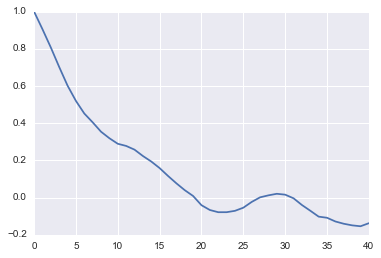

In [24]:
plt.plot(acf(Beta1))

In [25]:
delta = 0.0001
leap = 15
#Beta = np.array([0,0,0,0,0]).reshape(1,5)
#Tau = np.array([1])
Vars = np.array([0,0,0,0,0]).reshape(1,5)
N = 100

def log_grad_potential_energy(X, Y, Beta, Theta):
    dBeta = (1/np.exp(Theta)) * np.dot(X.T,(Y - np.dot(X,Beta))) - np.dot(la.inv(E0),(Beta - b0))
    dTheta = -n/2 - a + (1/np.exp(Theta))*((1/2)*np.dot((Y - np.dot(X,Beta)).T,(Y - np.dot(X,Beta))) + b)
    return np.append(dBeta, dTheta)

def potential_energy(X, Y, Beta, Theta):
    return(-((-n/2)*Theta - np.exp(Theta)/2 * np.dot(Y - np.dot(X,Beta).T,(Y - np.dot(X, Beta)))))

def kinetic_energy(p):
    return (np.sum(p.T.dot(p)/2))


for t in range(N):
            
    #Sample Random Momentum#
    p0 = np.random.randn(5)
    
    #Simulate Hamiltonian Dynamics
    #First 1/2 Step of Momentum
    p_star = p0 - (1/2)*delta/2*log_grad_potential_energy(X, Y, Vars[-1,:4], Vars[-1,4])
    
    #First full step of position/sample
    Vars_Star = Vars[-1,:] + delta*p_star
    
    #Full Steps:
    for i in range(leap):
        #Momentum
        p_star = p_star - delta*log_grad_potential_energy(X, Y, Vars_Star[:4], Vars_Star[4])
            
        #Position
        Vars_Star = Vars_Star + delta*p_star
        
    p_star = p_star - 1/2*log_grad_potential_energy(X, Y, Vars_Star[:4], Vars_Star[4])
    
    U0 = potential_energy(X, Y, Vars[-1,:4], Vars[-1,4])
    U_star = potential_energy(X, Y, Vars_Star[:4], Vars_Star[4])

    K0 = kinetic_energy(p0)
    K_star = kinetic_energy(p_star)
    
    # acceptance ratio
    alpha = U0 + K0 - (U_star + K_star)
    
    if np.log(np.random.random()) < alpha:
        Vars = np.vstack([Vars, Vars_Star])


print(Vars)

[[0 0 0 0 0]]
